In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")


In [3]:
data = pd.read_excel('Dataset.xlsx')

In [4]:
df = data.copy()
df.head()

,AGE,SEXE,TDT,PAR,CHOLESTEROL,GAJ,ECG,FCMAX,ANGINE,DEPRESSION,PENTE,CŒUR
0,40,homme,AA,140,289,0,Normal,172,Non,0.0,Ascendant,0
1,49,femme,DNA,160,180,0,Normal,156,Non,1.0,Plat,1
2,37,homme,AA,130,283,0,ST,98,Non,0.0,Ascendant,0
3,48,femme,ASY,138,214,0,Normal,108,Oui,1.5,Plat,1
4,54,homme,DNA,150,195,0,Normal,122,Non,0.0,Ascendant,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          918 non-null    int64  
 1   SEXE         918 non-null    object 
 2   TDT          918 non-null    object 
 3   PAR          918 non-null    int64  
 4   CHOLESTEROL  918 non-null    int64  
 5   GAJ          918 non-null    int64  
 6   ECG          918 non-null    object 
 7   FCMAX        918 non-null    int64  
 8   ANGINE       918 non-null    object 
 9   DEPRESSION   918 non-null    float64
 10  PENTE        918 non-null    object 
 11  CŒUR         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
quali_columns = df.select_dtypes("object").columns.tolist()
quali_columns.append('GAJ')
quali_columns

['SEXE', 'TDT', 'ECG', 'ANGINE', 'PENTE', 'GAJ']

In [7]:
quanti_columns = [col for col in df.columns if col not in quali_columns]
quanti_columns.remove('CŒUR')
quanti_columns

['AGE', 'PAR', 'CHOLESTEROL', 'FCMAX', 'DEPRESSION']

In [8]:
X = df.drop('CŒUR', axis=1)
y = df['CŒUR']

In [9]:
normalizer = RobustScaler()

In [10]:
for col in quanti_columns:
    X[col] = normalizer.fit_transform(X[[col]])

In [11]:
encoder = LabelEncoder()

In [12]:
for col in quali_columns:
    X[col] = encoder.fit_transform(X[[col]])
    

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(f"X_train: {X_train.shape}\t X_test: {X_test.shape}\ny_train: {y_train.shape}\t\t y_test: {y_test.shape}")

X_train: (642, 11)	 X_test: (276, 11)
y_train: (642,)		 y_test: (276,)


In [14]:
model = LogisticRegression(solver='liblinear',random_state=0)

In [15]:
def model_evaluation(myModel, x_train, y_train, x_test, y_test):
    
    myModel.fit(x_train, y_train)
    y_pred = myModel.predict(x_test)
    
    trainScore = myModel.score(x_train, y_train)
    testScore = myModel.score(x_test, y_test)    
    
    print(
        f"Évalution du modèle: {myModel} \n"
        f"Performance de l'entrainement: {trainScore} \n"
        f"Performance de test: {testScore} \n"
    )
    
    N, train_score, val_score = learning_curve(myModel, x_train, y_train,
                                                cv=5, scoring = 'f1', 
                                                train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12,8))
    plt.title("Courbe train-test du modèle")
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()    
      

Évalution du modèle: LogisticRegression(random_state=0, solver='liblinear') 
Performance de l'entrainement: 0.8644859813084113 
Performance de test: 0.822463768115942 



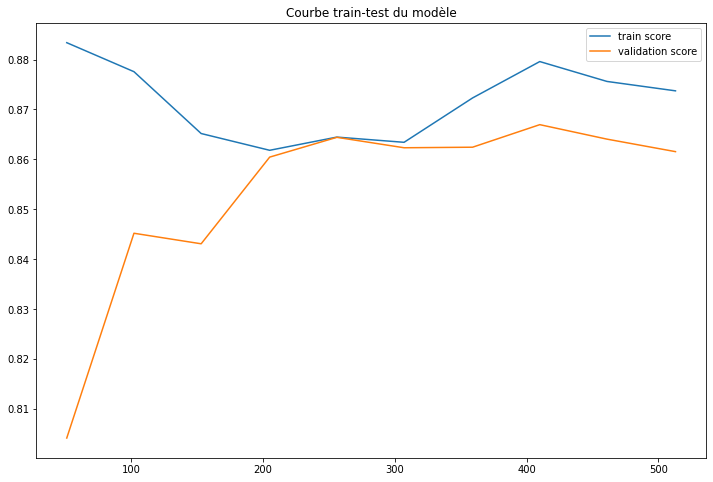

In [16]:
model_evaluation(model, X_train, y_train, X_test, y_test)

In [17]:
value_importances = []
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    value_importances.append(v)

In [18]:
value_importances =  pd.Series(value_importances, index=X_train.columns)
value_importances.sort_values(inplace=True)
value_importances

FCMAX         -0.488741
ECG           -0.406163
CHOLESTEROL   -0.317331
TDT           -0.185119
AGE           -0.000483
PAR            0.139912
DEPRESSION     0.610836
SEXE           1.110371
ANGINE         1.136361
GAJ            1.199475
PENTE          1.262989
dtype: float64

<BarContainer object of 11 artists>

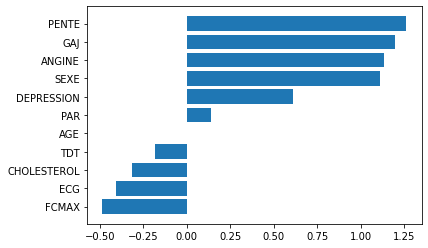

In [19]:
plt.barh(value_importances.index, value_importances.values)

In [45]:
def featureEvaluation(feature_list, x_train, y_train, x_test, y_test, train_score_list, test_score_list):
    
    model.fit(x_train[feature_list], y_train)
    y_pred = model.predict(x_test[feature_list])
    
    trainScore = model.score(x_train[feature_list], y_train)
    testScore = model.score(x_test[feature_list], y_test)

    train_score_list.append(trainScore)
    test_score_list.append(testScore)
    
    print(
        "Entraînement avec "+str(len(feature_list)) + f" variable(s). {feature_list} \n"
        f"Performance de l'entrainement: {trainScore} \n"
        f"Performance de test: {testScore} \n"
    )

    print("==="*50)

In [46]:
trainScoreList = []
testScoreList = []

for i in range(len(value_importances.index)):
    featureEvaluation(value_importances.sort_values().index[0: i+1], X_train, y_train, X_test, y_test, trainScoreList, testScoreList)

Entraînement avec 1 variable(s). Index(['FCMAX'], dtype='object') 
Performance de l'entrainement: 0.6744548286604362 
Performance de test: 0.6557971014492754 

Entraînement avec 2 variable(s). Index(['FCMAX', 'ECG'], dtype='object') 
Performance de l'entrainement: 0.6853582554517134 
Performance de test: 0.6594202898550725 

Entraînement avec 3 variable(s). Index(['FCMAX', 'ECG', 'CHOLESTEROL'], dtype='object') 
Performance de l'entrainement: 0.6838006230529595 
Performance de test: 0.6920289855072463 

Entraînement avec 4 variable(s). Index(['FCMAX', 'ECG', 'CHOLESTEROL', 'TDT'], dtype='object') 
Performance de l'entrainement: 0.6838006230529595 
Performance de test: 0.6920289855072463 

Entraînement avec 5 variable(s). Index(['FCMAX', 'ECG', 'CHOLESTEROL', 'TDT', 'AGE'], dtype='object') 
Performance de l'entrainement: 0.7024922118380063 
Performance de test: 0.6884057971014492 

Entraînement avec 6 variable(s). Index(['FCMAX', 'ECG', 'CHOLESTEROL', 'TDT', 'AGE', 'PAR'], dtype='object

In [41]:
df_fearureScores = pd.DataFrame(
    data = list(zip(trainScoreList, testScoreList)), 
    columns = ['Train Scores', 'Test Scores'], 
)

In [42]:
df_fearureScores.index = pd.RangeIndex(1, 1+len(df_fearureScores))
df_fearureScores

,Train Scores,Test Scores
1,0.674455,0.655797
2,0.685358,0.659420
3,0.683801,0.692029
4,0.683801,0.692029
5,0.702492,0.688406
6,0.700935,0.673913
7,0.758567,0.746377
8,0.771028,0.786232
9,0.802181,0.811594
10,0.819315,0.815217


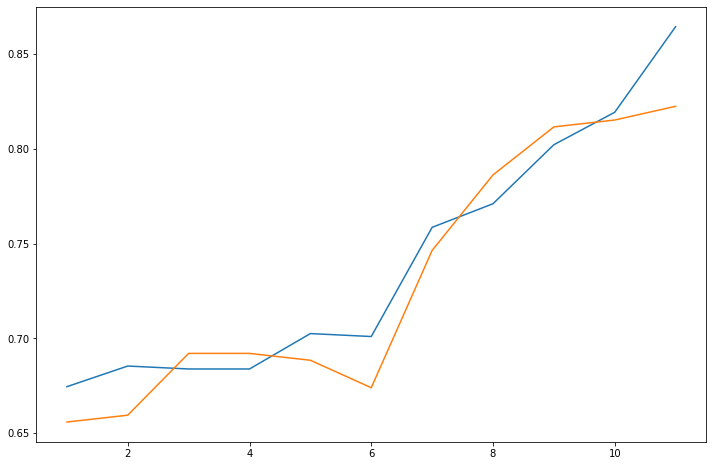

In [43]:
plt.figure(figsize=(12,8))
plt.plot(df_fearureScores.index, df_fearureScores['Train Scores'])
plt.plot(df_fearureScores.index, df_fearureScores['Test Scores'])

plt.show()

## POLYNOMIAL FEATURES

In [25]:
polynomialFeatures = PolynomialFeatures(degree=2)

In [26]:
X_1 = X.copy()
y_1 = y.copy()

In [27]:
for col in quanti_columns:
    X_1[col] = normalizer.fit_transform(X_1[[col]])

In [28]:
for col in quali_columns:
    X_1[col] = encoder.fit_transform(X_1[[col]])

In [29]:
X_poly = pd.DataFrame(polynomialFeatures.fit_transform(X_1), columns=polynomialFeatures.get_feature_names(X_1.columns))
X_poly.head()

,1,AGE,SEXE,TDT,PAR,CHOLESTEROL,GAJ,ECG,FCMAX,ANGINE,...,FCMAX^2,FCMAX ANGINE,FCMAX DEPRESSION,FCMAX PENTE,ANGINE^2,ANGINE DEPRESSION,ANGINE PENTE,DEPRESSION^2,DEPRESSION PENTE,PENTE^2
0,1.0,-1.076923,1.0,0.0,0.5,0.704000,0.0,1.0,0.944444,0.0,...,0.891975,0.000000,-0.377778,0.000000,0.0,-0.0,0.0,0.160000,-0.000000,0.0
1,1.0,-0.384615,0.0,3.0,1.5,-0.458667,0.0,1.0,0.500000,0.0,...,0.250000,0.000000,0.133333,1.000000,0.0,0.0,0.0,0.071111,0.533333,4.0
2,1.0,-1.307692,1.0,0.0,0.0,0.640000,0.0,2.0,-1.111111,0.0,...,1.234568,-0.000000,0.444444,-0.000000,0.0,-0.0,0.0,0.160000,-0.000000,0.0
3,1.0,-0.461538,0.0,1.0,0.4,-0.096000,0.0,1.0,-0.833333,1.0,...,0.694444,-0.833333,-0.500000,-1.666667,1.0,0.6,2.0,0.360000,1.200000,4.0
4,1.0,0.000000,1.0,3.0,1.0,-0.298667,0.0,1.0,-0.444444,0.0,...,0.197531,-0.000000,0.177778,-0.000000,0.0,-0.0,0.0,0.160000,-0.000000,0.0


In [30]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_poly, y_1, test_size=0.3, random_state=0)
print(f"X_train: {X_train_1.shape}\t X_test: {X_test_1.shape}\ny_train: {y_train_1.shape}\t\t y_test: {y_test_1.shape}")

X_train: (642, 78)	 X_test: (276, 78)
y_train: (642,)		 y_test: (276,)


Évalution du modèle: LogisticRegression(random_state=0, solver='liblinear') 
Performance de l'entrainement: 0.9018691588785047 
Performance de test: 0.8514492753623188 



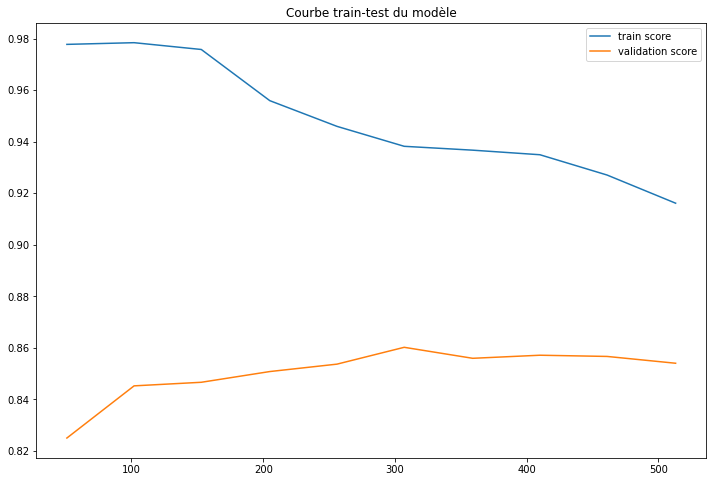

In [31]:
model_evaluation(model, X_train_1, y_train_1, X_test_1, y_test_1)

In [32]:
value_importances_poly = []
importance_poly = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance_poly):
    value_importances_poly.append(v)

In [33]:
value_importances_poly =  pd.Series(value_importances_poly, index=X_train_1.columns)
value_importances_poly.sort_values(inplace=True)
value_importances_poly

1                   -1.425843
ECG                 -1.161012
CHOLESTEROL GAJ     -1.157932
FCMAX PENTE         -0.829027
CHOLESTEROL         -0.810139
                       ...   
CHOLESTEROL FCMAX    0.791710
DEPRESSION^2         0.896605
SEXE CHOLESTEROL     1.043967
TDT                  1.078099
DEPRESSION           1.078850
Length: 78, dtype: float64

<BarContainer object of 78 artists>

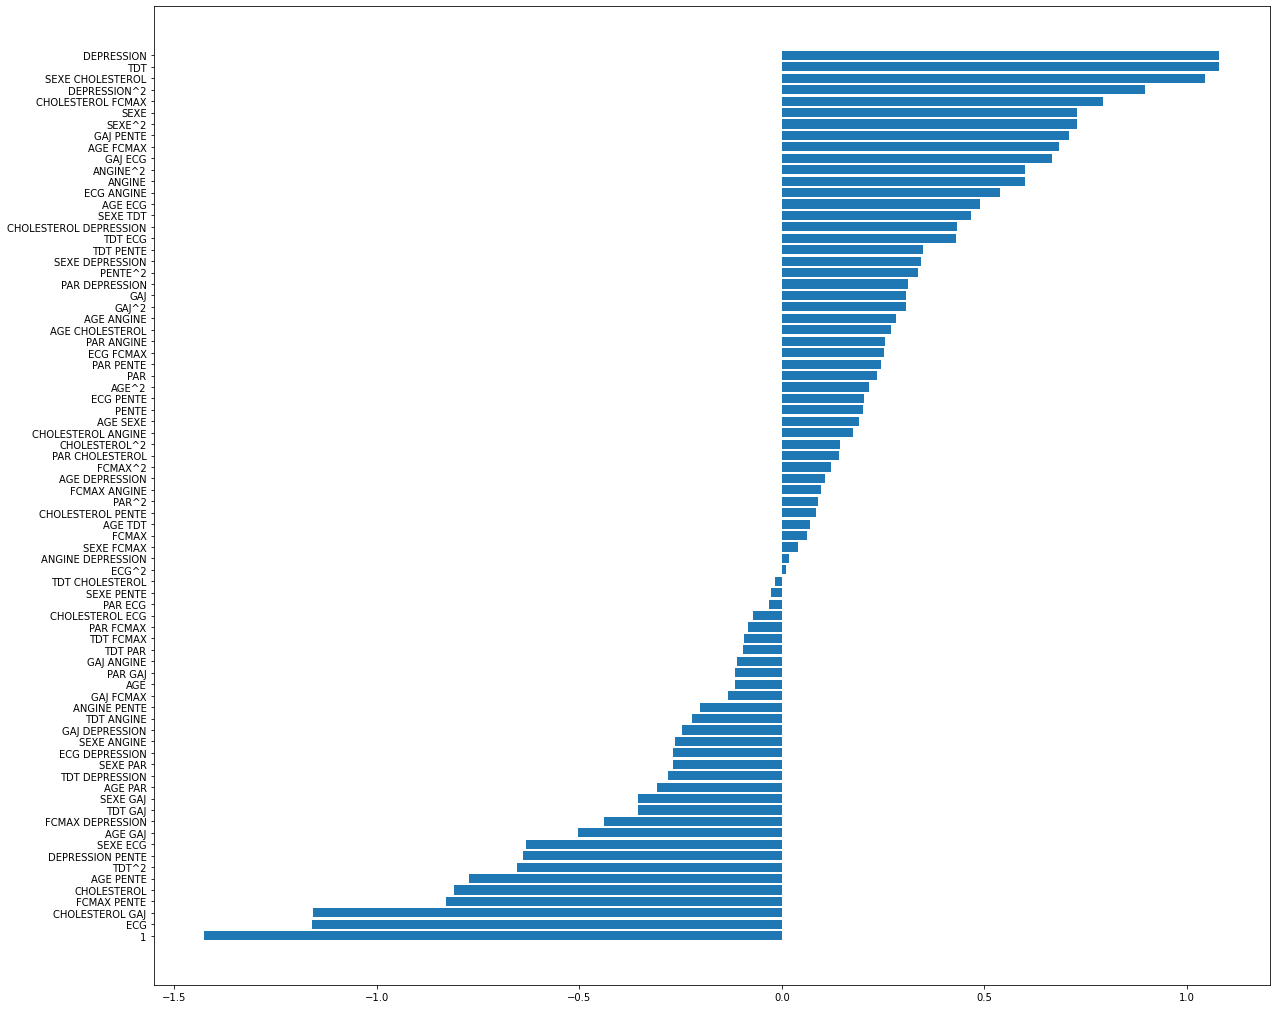

In [37]:
plt.figure(figsize=(20,18))
plt.barh(value_importances_poly.index, value_importances_poly.values)

In [47]:
trainScoreList_poly = []
testScoreList_poly = []

for i in range(len(value_importances_poly.index)):
    featureEvaluation(value_importances_poly.sort_values().index[0: i+1], X_train_1, y_train_1, X_test_1, y_test, trainScoreList_poly, testScoreList_poly)

Entraînement avec 1 variable(s). Index(['1'], dtype='object') 
Performance de l'entrainement: 0.5373831775700935 
Performance de test: 0.5905797101449275 

Entraînement avec 2 variable(s). Index(['1', 'ECG'], dtype='object') 
Performance de l'entrainement: 0.5373831775700935 
Performance de test: 0.5905797101449275 

Entraînement avec 3 variable(s). Index(['1', 'ECG', 'CHOLESTEROL GAJ'], dtype='object') 
Performance de l'entrainement: 0.5124610591900312 
Performance de test: 0.5181159420289855 

Entraînement avec 4 variable(s). Index(['1', 'ECG', 'CHOLESTEROL GAJ', 'FCMAX PENTE'], dtype='object') 
Performance de l'entrainement: 0.7398753894080997 
Performance de test: 0.7028985507246377 

Entraînement avec 5 variable(s). Index(['1', 'ECG', 'CHOLESTEROL GAJ', 'FCMAX PENTE', 'CHOLESTEROL'], dtype='object') 
Performance de l'entrainement: 0.7429906542056075 
Performance de test: 0.7028985507246377 

Entraînement avec 6 variable(s). Index(['1', 'ECG', 'CHOLESTEROL GAJ', 'FCMAX PENTE', 'CHO

In [49]:
df_fearureScores_poly = pd.DataFrame(
    data = list(zip(trainScoreList_poly, testScoreList_poly)), 
    columns = ['Train Scores_poly', 'Test Scores_poly'], 
)

In [50]:
df_fearureScores_poly.index = pd.RangeIndex(1, 1+len(df_fearureScores_poly))
df_fearureScores_poly

,Train Scores_poly,Test Scores_poly
1,0.537383,0.590580
2,0.537383,0.590580
3,0.512461,0.518116
4,0.739875,0.702899
5,0.742991,0.702899
...,...,...
74,0.895639,0.840580
75,0.906542,0.851449
76,0.908100,0.840580
77,0.904984,0.836957


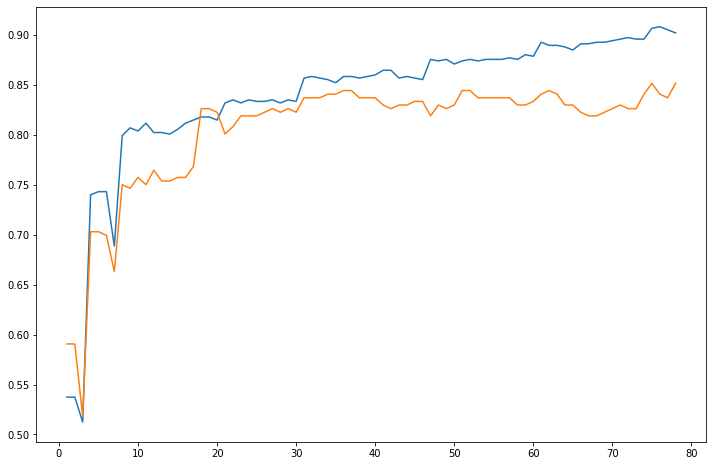

In [54]:
plt.figure(figsize=(12,8))
plt.plot(df_fearureScores_poly.index, df_fearureScores_poly['Train Scores_poly'])
plt.plot(df_fearureScores_poly.index, df_fearureScores_poly['Test Scores_poly'])

plt.show()